In [1]:
# standard imports
import os
import sys

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spectral

from IPython.display import HTML, JSON
from osgeo import gdal

# use GDAL specific exceptions
gdal.UseExceptions()

In [2]:
files = [
    './Vzorka_Asfalt/asfalt_geo.bsq',
    './Vzorka_Kroviny/kroviny_geo.bsq',
    './Vzorka_Polna cesta/polna_cesta_geo.bsq'
]

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/spectral/graphics/graphics.py:562: UserWarning: Unable to interpret "default bands" in image metadata. Defaulting to first, middle, & last band.
  warnings.warn(msg)


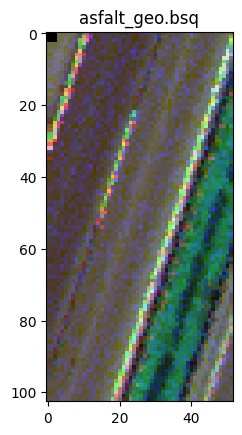

asfalt_geo.bsq (474, 103, 52)


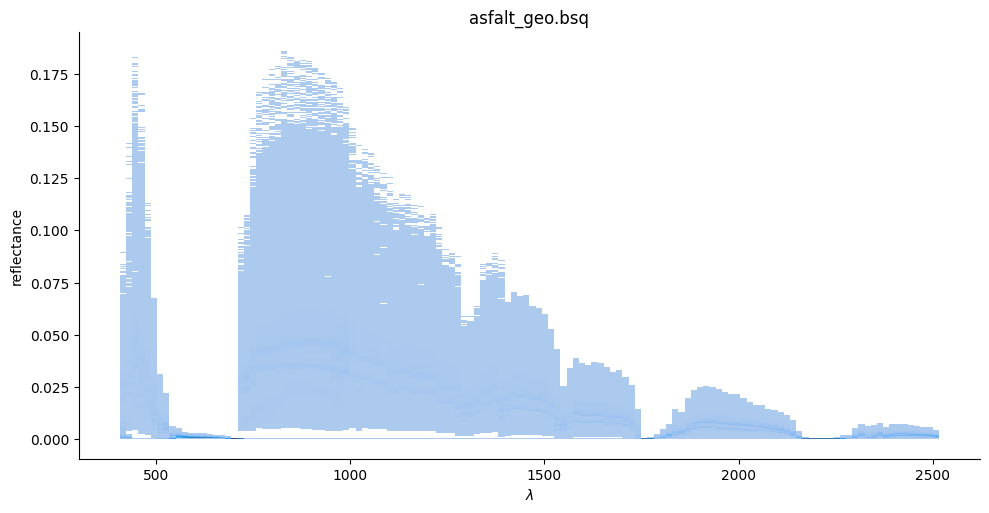

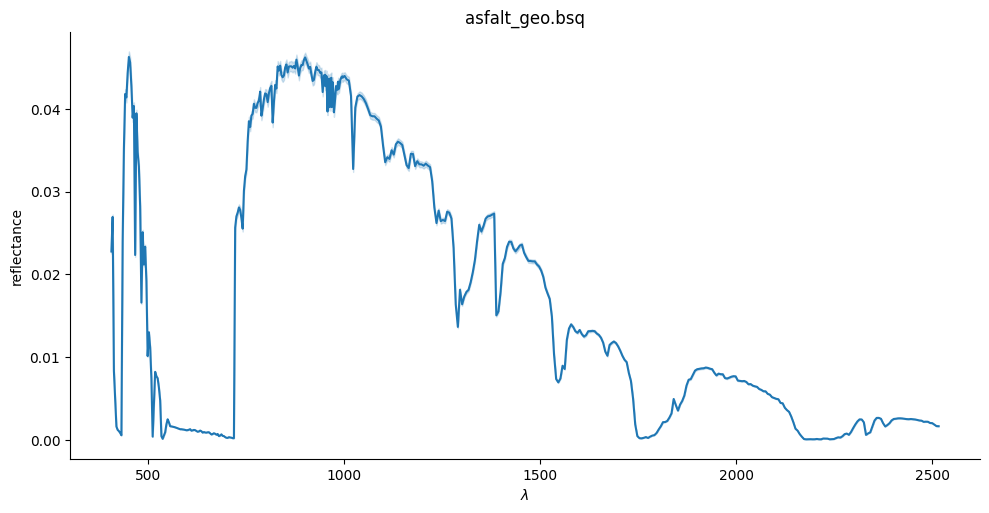

,reflectance,lambda
count,2.538744e+06,2.538744e+06
mean,1.800507e-02,1.329006e+03
std,2.018556e-02,6.248049e+02
min,0.000000e+00,4.067477e+02
25%,1.830155e-03,7.828967e+02
50%,1.010011e-02,1.227493e+03
75%,3.060337e-02,1.873135e+03
max,1.857653e-01,2.516052e+03


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/spectral/graphics/graphics.py:562: UserWarning: Unable to interpret "default bands" in image metadata. Defaulting to first, middle, & last band.
  warnings.warn(msg)


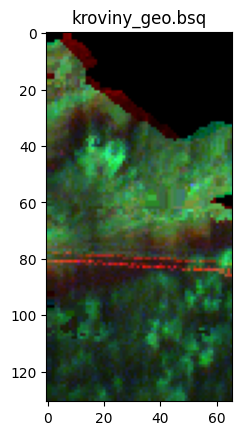

kroviny_geo.bsq (474, 131, 66)


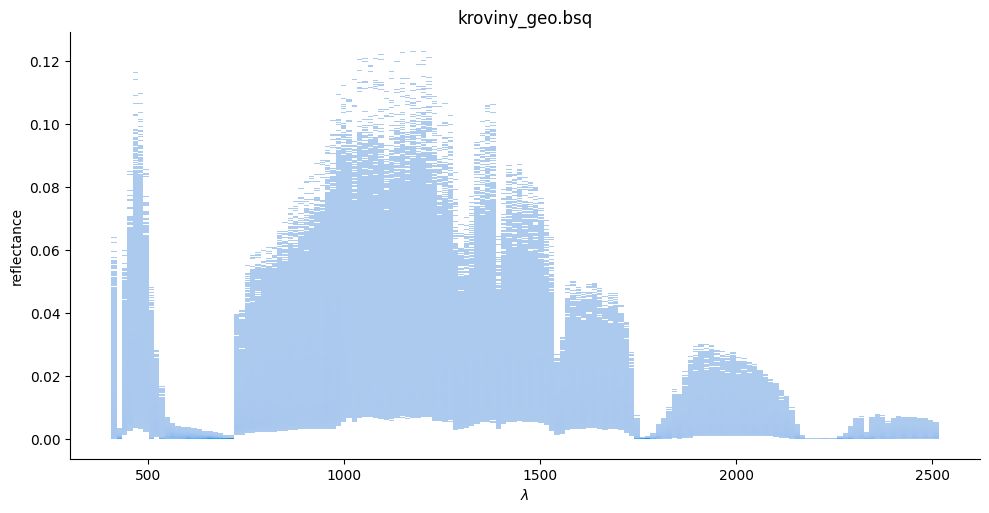

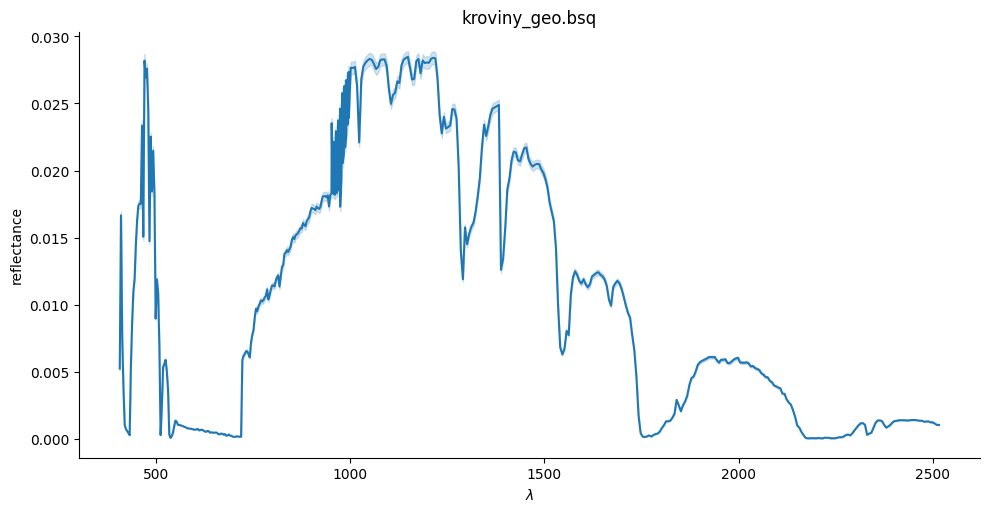

,reflectance,lambda
count,4.098204e+06,4.098204e+06
mean,1.049248e-02,1.329006e+03
std,1.454024e-02,6.248048e+02
min,0.000000e+00,4.067477e+02
25%,2.049668e-04,7.828967e+02
50%,3.882875e-03,1.227493e+03
75%,1.544546e-02,1.873135e+03
max,1.229816e-01,2.516052e+03


/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/spectral/graphics/graphics.py:562: UserWarning: Unable to interpret "default bands" in image metadata. Defaulting to first, middle, & last band.
  warnings.warn(msg)


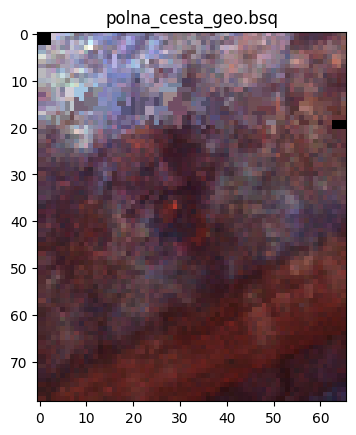

polna_cesta_geo.bsq (186, 79, 66)


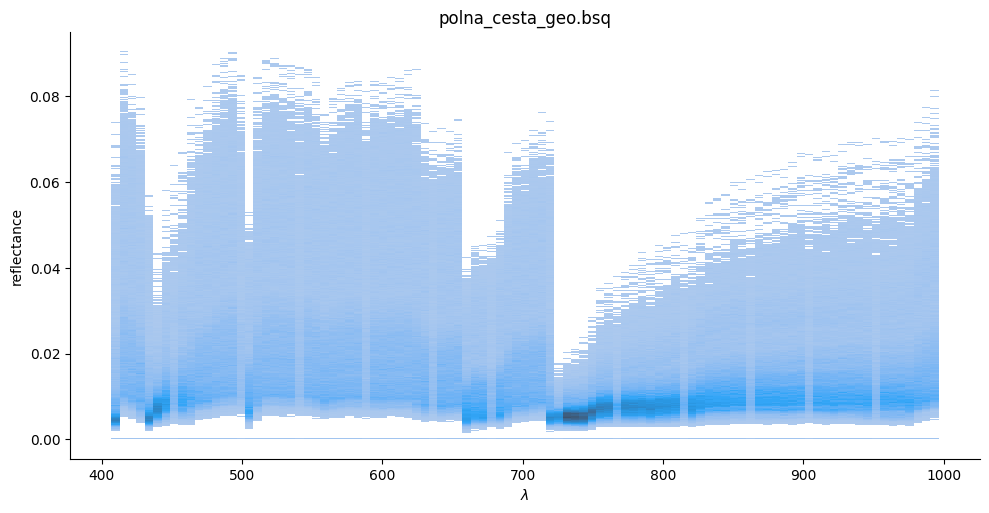

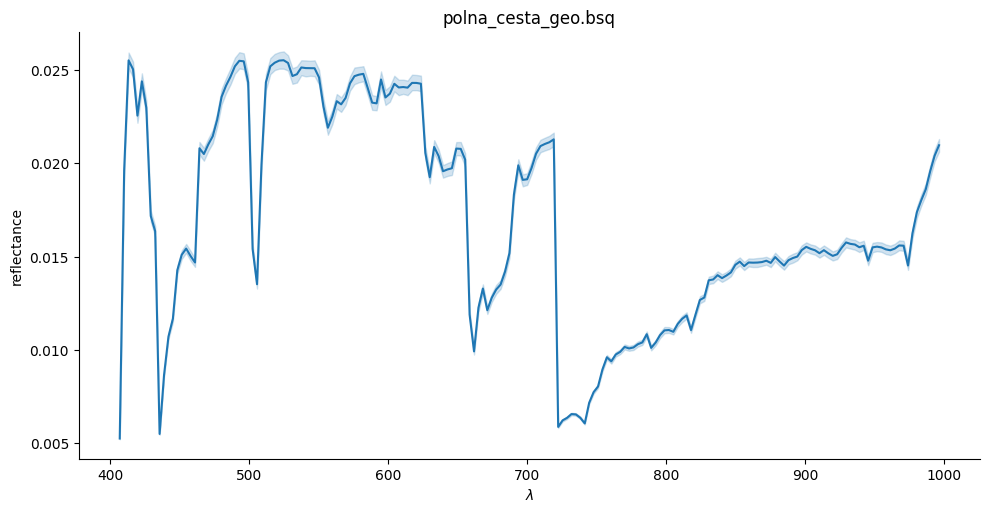

,reflectance,lambda
count,969804.000000,969804.000000
mean,0.017031,701.610352
std,0.012307,171.156815
min,0.000000,406.747681
25%,0.008714,553.382019
50%,0.013025,701.610260
75%,0.021191,849.838440
max,0.090481,996.472839


In [3]:
def plot_wavelengths_v3(df, title=None, filename=None, fileformat='pdf', **args):
    g = sns.relplot(df, x='lambda', y='reflectance', kind='line', **args)
    g.set(xticklabels=[])
    if title is not None:
        g.fig.suptitle(title)
        g.fig.subplots_adjust(top=0.8);
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()

    
df_global = pd.DataFrame([])

for file in files:
    
    title = os.path.basename(file)
    label = re.sub(r'_geo.*', '', title)
    
    display(HTML('<h2>%s</h2><hr/>' % title))
    
    ds = gdal.Open(file)

    hdr_file = re.sub(r'bsq$' , 'hdr', file)
    img = spectral.open_image(hdr_file)
    plt.imshow(spectral.get_rgb(img))
    plt.title(title)
    plt.show()

    data = ds.ReadAsArray()
    print(title, data.shape)

    df_data = []
    for b in range(data.shape[0]):
        for y in range(data.shape[1]):
            for x in range(data.shape[2]):
                df_data.append(
                    {
                        'y': y,
                        'x': x,
                        'band': b+1,
                        'reflectance': data[b,y,x]
                    }
                )
    df = pd.DataFrame.from_dict(df_data)
    # display(df)

    md = ds.GetMetadata()
    df_wavelengths = pd.DataFrame.from_dict(
        {int(re.sub(r'Band_(\d+)', r'\1', k)) : np.float32(v) for k,v in md.items()},
        orient='index',
        columns=['lambda']
    )
    df_wavelengths.index = df_wavelengths.index.sort_values()
    df_wavelengths.index = df_wavelengths.index.rename('band')
    df_wavelengths = df_wavelengths.reset_index()
    # display(df_wavelengths)

    df = pd.merge(df, df_wavelengths, how='left', left_on='band', right_on='band')
    # display(df)

    ax = sns.displot(df, x='lambda', y='reflectance', aspect=2)
    ax.set(xlabel=r'$\lambda$')
    plt.title(title)
    plt.show()

    ax = sns.relplot(df, x='lambda', y='reflectance', kind='line', aspect=2)
    ax.set(xlabel=r'$\lambda$')
    plt.title(title)
    plt.show()
    
    df['label'] = label
    
    df_global = pd.concat([df_global, df], axis=0)

    display(df.drop(['x', 'y', 'band'], axis=1).describe())

In [4]:
df_global

,y,x,band,reflectance,lambda,label
0,0,0,1,0.000000,406.747681,asfalt
1,0,1,1,0.000000,406.747681,asfalt
2,0,2,1,0.000000,406.747681,asfalt
3,0,3,1,0.031237,406.747681,asfalt
4,0,4,1,0.030090,406.747681,asfalt
...,...,...,...,...,...,...
969799,78,61,186,0.016370,719.142639,polna_cesta
969800,78,62,186,0.017624,719.142639,polna_cesta
969801,78,63,186,0.016896,719.142639,polna_cesta
969802,78,64,186,0.016136,719.142639,polna_cesta


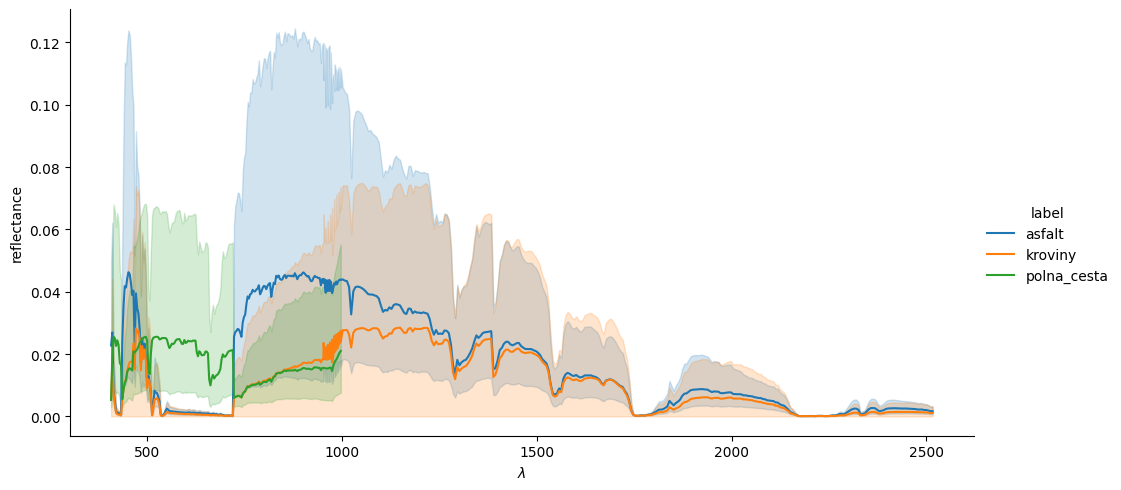

In [5]:
ax = sns.relplot(df_global, x='lambda', y='reflectance', hue='label', kind='line', errorbar=('pi', 95), aspect=2)
ax.set(xlabel=r'$\lambda$')
plt.show()

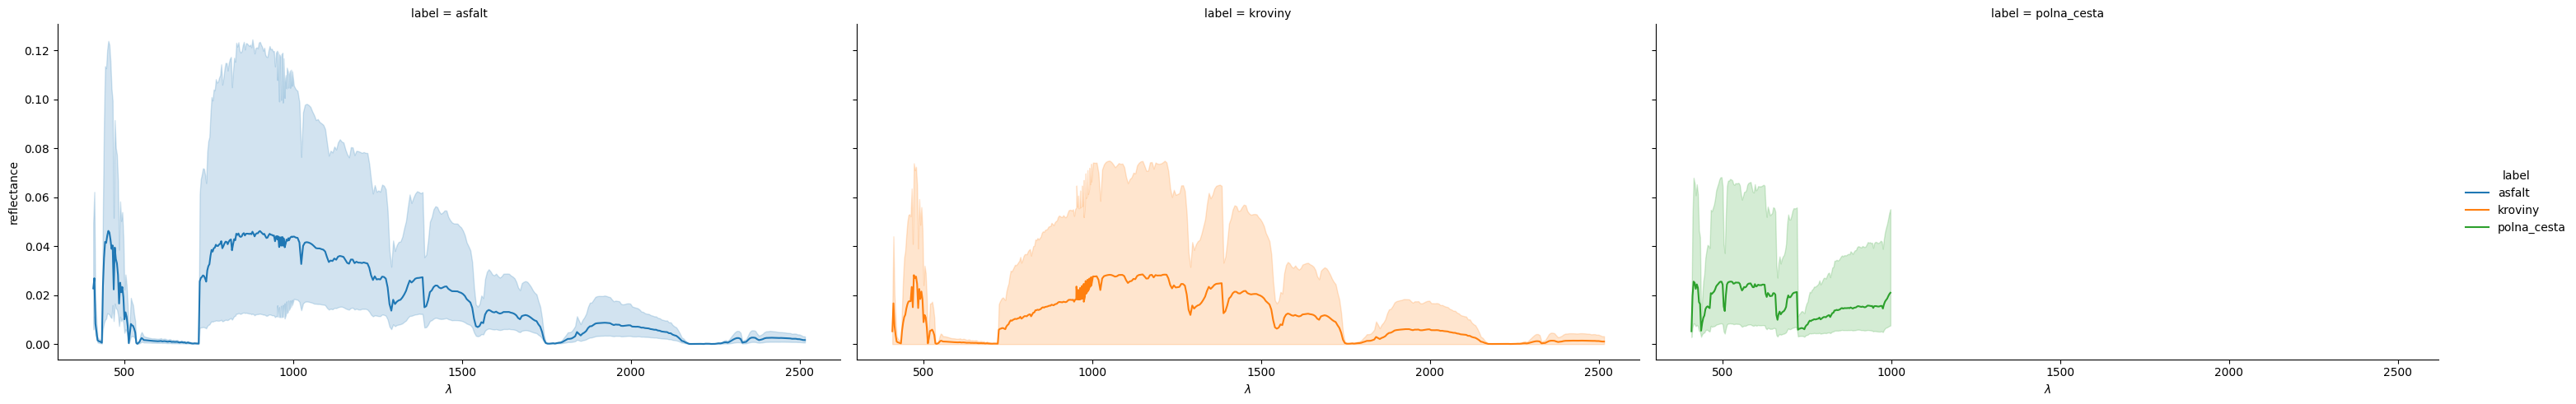

In [6]:
ax = sns.relplot(df_global, x='lambda', y='reflectance', hue='label', col='label', kind='line', errorbar=('pi', 95), aspect=2)
for x in ax.axes[0,:]:
    x.set_xlabel(r'$\lambda$')
plt.show()

In [7]:
visible_mask = (df_global['lambda'] >= 380) & (df_global['lambda'] <= 750)
df_global_visible = df_global[visible_mask]
df_global_visible

,y,x,band,reflectance,lambda,label
0,0,0,1,0.000000,406.747681,asfalt
1,0,1,1,0.000000,406.747681,asfalt
2,0,2,1,0.000000,406.747681,asfalt
3,0,3,1,0.031237,406.747681,asfalt
4,0,4,1,0.030090,406.747681,asfalt
...,...,...,...,...,...,...
969799,78,61,186,0.016370,719.142639,polna_cesta
969800,78,62,186,0.017624,719.142639,polna_cesta
969801,78,63,186,0.016896,719.142639,polna_cesta
969802,78,64,186,0.016136,719.142639,polna_cesta


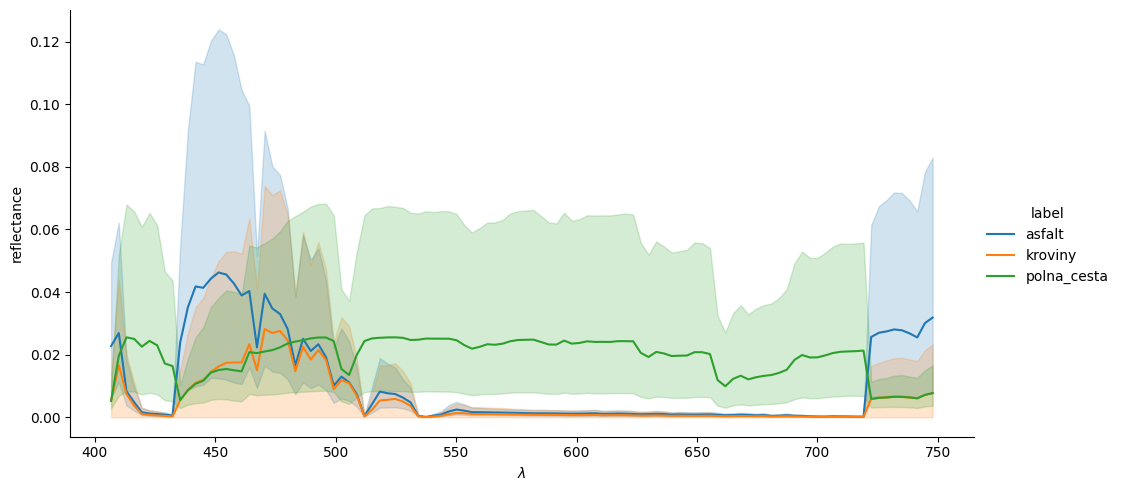

In [8]:
ax = sns.relplot(df_global_visible, x='lambda', y='reflectance', hue='label', kind='line', errorbar=('pi', 95), aspect=2)
ax.set(xlabel=r'$\lambda$')
plt.show()

,index,y,x,band,reflectance,lambda,label
0,0,0,0,1,0.000000,406.747681,asfalt
1,1,0,1,1,0.000000,406.747681,asfalt
2,2,0,2,1,0.000000,406.747681,asfalt
3,3,0,3,1,0.031237,406.747681,asfalt
4,4,0,4,1,0.030090,406.747681,asfalt
...,...,...,...,...,...,...,...
2538739,2538739,102,47,474,0.000040,719.142639,asfalt
2538740,2538740,102,48,474,0.000155,719.142639,asfalt
2538741,2538741,102,49,474,0.000197,719.142639,asfalt
2538742,2538742,102,50,474,0.000192,719.142639,asfalt


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


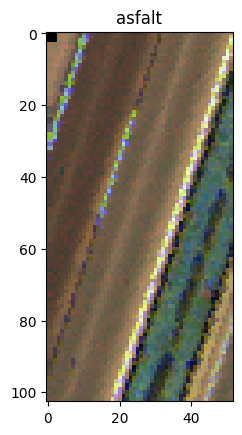

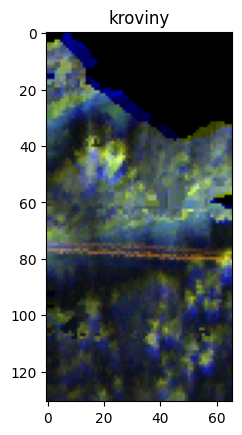

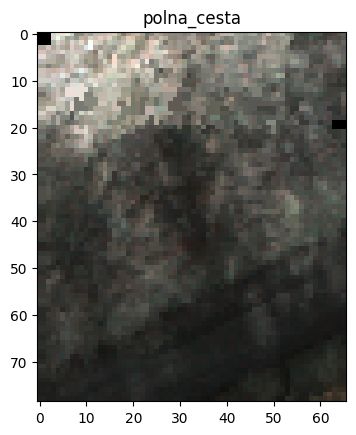

In [93]:
red = (750+620)/2
green = (570+495)/2
blue = (495+450)/2

for label in df_global['label'].unique():
    img_data = df_global[df_global['label']==label].reset_index()

    h = img_data['y'].max()+1
    w = img_data['x'].max()+1
    b = img_data['band'].count()//(h*w)

    img = img_data.sort_values(by='index')['reflectance'].values.reshape(b, h, w)

    band_r = img_data.iloc[(img_data['lambda']-red).abs().argsort()[:1]]['band'].values[0]
    band_g = img_data.iloc[(img_data['lambda']-green).abs().argsort()[:1]]['band'].values[0]
    band_b = img_data.iloc[(img_data['lambda']-blue).abs().argsort()[:1]]['band'].values[0]
    bands = (band_r, band_g, band_b)

    spectral.imshow(np.moveaxis(img, (0,1,2), (2,0,1)), bands=bands, title=label)